<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C7/C7.html"><img src="../data/C7_nav.png" width="100"  style="float:right;" alt="C7"></a>
<h1>Diagonal Matching</h1> 
</div>

<br/>

<p>
Following Section 7.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook a simple diagonal matching strategy for comparing a short sequence with subsequences of a longer sequence. This procedure has been used for audio matching in the following article.
</p> 

<ul>
<li><span style="color:black">
Meinard Müller, Frank Kurth, and Michael Clausen: <strong><a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_AudioMatching_ISMIR.pdf">Audio Matching via Chroma-Based Statistical Features.</a></strong> Proceedings of the International Conference on Music Information Retrieval (ISMIR), London, UK, pp. 288–295, 2005.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerKC05_ChromaFeatures_ISMIR.txt"> Bibtex </a>
</span></li>
</ul>    

## Matching Function

The following subsequence matching technique is motivated by the task of [**audio matching**](../C7/C7S2_AudioMatching.html), which was introduced in the [FMP notbook on content-based audio retrieval](../C7/C7_ContentBasedAudioRetrieval.html). Recall that the goal of audio matching is to retrieve all audio excerpts that musically correspond to a short query audio clip. From an abstract point of view, let $X=(x_1,x_2,\ldots,x_N)$ and $Y=(y_1,y_2,\ldots,y_M)$ be two feature sequences, representing a query $\mathcal{Q}$ and a document $\mathcal{D}$, respectively. The length $N$ of the query is typically short in comparison with the length $M$ of the database document. To see if and where the query $\mathcal{Q}$ is somehow "contained" in $\mathcal{D}$, we shift the sequence $X$ over the sequence $Y$ and locally compare $X$ with suitable subsequences of $Y$. Every subsequence of $Y$ that is similar or, equivalently, has a small distance to $X$ is considered a **match** for the query. 

There are many ways for locally comparing $X$ with subsequences of $Y$. We now introduce a simple procedure, which is referred to as **diagonal matching**. First of all, we need to fix a local cost measure (or local distance measure) to compare the chroma vectors of the sequences $X$ and $Y$. In the following, we assume that all features are normalized with regard to the [**Euclidean norm**](../C3/C3S1_FeatureNormalization.html) and then use the distance measure $c$ based on the **inner product** (or **dot product**):

\begin{equation}
c(x,y) = 1- \langle x,y\rangle = 1 - \sum_{k=1}^K x(k)y(k)
\end{equation}

for two $K$-dimensional vectors $x\in\mathbb{R}^K$ and $y\in\mathbb{R}^K$ with $\|x\|_2=\|y\|_2=1$. Furthermore, assuming that all feature vectors have **non-negative entries**, we have $c(x,y)\in[0,1]$ with $c(x,y)=0$ if and only if $x=y$. One simple way for comparing two feature sequences that share
the same length is to compute the average distance between corresponding vectors of the two sequences. Doing so, we compare the query sequence $X=(x_1,\ldots,x_N)$ with all subsequences $(y_{1+m},\ldots,y_{N+m})$ of $Y$ having the same length $N$ as the query, where $m\in[0:M-N]$ denotes the shift index. This procedure yields a **matching function** $\Delta_\mathrm{Diag}:[0:M-N]\to\mathbb{R}$ defined by 

\begin{equation}
 \Delta_\mathrm{Diag}(m) := \frac{1}{N}\sum_{n=1}^{N} c(x_n,y_{n+m}).
\end{equation}

We now slightly reformulate the way this matching function is computed. Let $\mathbf{C}\in\mathbb{R}^{N\times M}$ be 
the **cost matrix** given by

\begin{equation}
\mathbf{C}(n,m):=c(x_n,y_m)
\end{equation}

for $n\in[1:N]$ and $m\in[1:M]$. Then the value $\Delta_\mathrm{Diag}(m)$ is obtained (up to the normalization by the query length) by summing up diagonals of the matrix $\mathbf{C}$ as illustrated by the next figure. This explains why this procedure is denoted as "diagonal" matching.

<img src="../data/C7/FMP_C7_F11.png" width="400px" align="middle" alt="FMP_C7_F11.png">

## Implementation

In the following code cell, we implement the diagonal matching procedure and apply it, as a simple example, to synthetically generated sequences $X$ and $Y$. In the subsequent example, the sequence $Y$ contains five  subsequences that are similar to $X$ (starting at positions $m=20$, $40$, $60$, $80$, $100$, respectively):

* The first occurrence starting at $m=20$ is an exact copy of $X$.
* The occurrences at $m=40$ and $m=60$ are noisy versions of $X$. 
* The occurrence at $m=80$ is a stretched (slower) version of $X$.
* The occurrence at $m=100$ is a compressed (faster) version of $X$.

As can be seen in the following figure, the matching function $\Delta_\mathrm{Diag}$ reveals local minima at the expected positions. While the first minimum at $m=20$ is zero, the next two minima at $m=40$ and $m=60$ are still pronounced (with a matching value being close to zero). However, due to the stretching and compression, the diagonal matching procedure is not capable of capturing well the last two subsequences at $m=80$ and $m=100$.

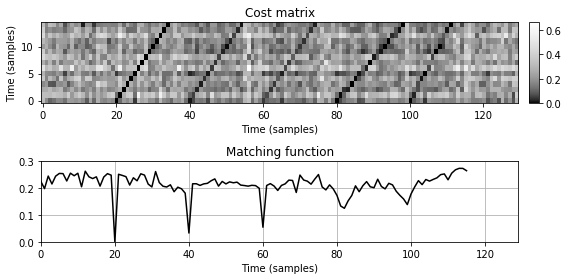

In [1]:
import sys
import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('..')
import LibFMP.B
%matplotlib inline

def scale_tempo_sequence(X, factor=1):
    """Scales a sequence (given as feature matrix) along time (second dimension)

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        X: Feature sequences (given as K x N matrix)
        factor: Scaling factor (resulting in length "round(factor * N)"")

    Returns:
        X_new: Scaled feature sequence
        N_new: Length of scaled feature sequence
    """
    N = X.shape[1]
    t = np.linspace(0, 1, num=N, endpoint=True)
    N_new = np.round(factor * N).astype(int)
    t_new = np.linspace(0, 1, num=N_new, endpoint=True)
    X_new = scipy.interpolate.interp1d(t, X, axis=1)(t_new)
    return X_new, N_new

def cost_matrix_dot(X, Y):
    """Computes cost matrix via dot product

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        X, Y: Feature seqeuences (given as K x N and K x M matrices)

    Returns:
        C: cost matrix
    """
    return 1 - np.dot(X.T, Y)

def matching_function_diag(C, cyclic=False):
    """Computes diagonal matching function

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        C: Cost matrix
        cyclic: If "True" then matching is done cyclically

    Returns:
        Delta: Matching function
    """
    N, M = C.shape
    assert N <= M, "N <= M is required"
    Delta = C[0, :]
    for n in range(1, N):
        Delta = Delta + np.roll(C[n, :], -n)
    Delta = Delta / N
    if cyclic is False:
        Delta[M-N+1:M] = np.inf
    return Delta

# Create snythetic example for sequences X and Y
N = 15
M = 130
feature_dim = 12
np.random.seed(2)
X = np.random.random((feature_dim, N))
Y = np.random.random((feature_dim, M))
Y[:, 20:20+N] = X
Y[:, 40:40+N] = X + 0.5 * np.random.random((feature_dim, N))
Y[:, 60:60+N] = X + 0.8 * np.random.random((feature_dim, N))
X_slow, N_slow = scale_tempo_sequence(X, factor=1.25)
Y[:, 80:80+N_slow] = X_slow
X_fast, N_fast = scale_tempo_sequence(X, factor=0.8)
Y[:, 100:100+N_fast] = X_fast
Y = librosa.util.normalize(Y, norm=2)
X = librosa.util.normalize(X, norm=2)

# Compute cost matrix and matching function
C = cost_matrix_dot(X, Y)
Delta = matching_function_diag(C)

# Visualization
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [1, 1]}, figsize=(8, 4))  
cmap = LibFMP.B.compressed_gray_cmap(alpha=-10, reverse=True)
LibFMP.B.plot_matrix(C, title='Cost matrix', xlabel='Time (samples)', ylabel='Time (samples)', 
                     ax=[ax[0, 0], ax[0, 1]], colorbar=True, cmap=cmap)

LibFMP.B.plot_signal(Delta, ax=ax[1,0], xlabel='Time (samples)', ylabel='',
                     title = 'Matching function', color='k')
ax[1, 0].grid()
ax[1, 1].axis('off')
plt.tight_layout()

## Retrieval Procedure

We now discuss how the matching function can be applied for retrieving all matches that are similar to the query fragment. In the following, we assume that the database is represented by a single document $\mathcal{D}$ (e.g., by concatenating all document sequences). To determine the best match between $\mathcal{Q}$ and $\mathcal{D}$, we simply look for the index $m^\ast\in[0:M-N]$ that minimizes the matching  function $\Delta_\mathrm{Diag}$:

\begin{equation}
   m^\ast := \underset{m\in[0:M-N]}{\mathrm{argmin}} \,\,\Delta_\mathrm{Diag}(m).
\end{equation}

The best match is then given by the subsequence

\begin{equation}
   Y(1+m^\ast:N+m^\ast) := (y_{1+m^\ast},\ldots,y_{N+m^\ast}).
\end{equation}

To obtain further matches, we exclude a neighborhood of the best match from further considerations. For example, one may exclude a neighborhood of $\rho= \lfloor N/2 \rfloor$ around $m^\ast$, e.g., by setting $\Delta_\mathrm{Diag}(m)=\infty$ for $m\in [m^\ast-\rho:m^\ast+\rho]\cap [0:M-N]$. This ensures that the subsequent matches do not overlap by more than half the query length. To find subsequent matches, the latter procedure is repeated until a certain number of matches is obtained or a specified distance threshold is exceeded.

In the following code cell, we implement this retrieval procedure. Besides the parameter $\rho$, we introduce a parameter $\tau$ for restricting the matching values (i.e., we require $\Delta_\mathrm{Diag}(m^\ast)\leq \tau$) and a parameters that specifies the maximum number of matches to be retrieved. Continuing with our synthetic example, we indicate in the visualization the minimizing matching positions (using a red dot) and the matching subsequence (using a transparent red rectangle).

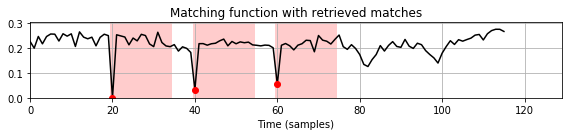

In [2]:
def mininma_from_matching_function(Delta, rho=2, tau=0.2, num=None):
    """Derives local minima positions of matching function in an iterative fashion

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        Delta: Matching function
        rho: Parameter to exclude neighborhood of a matching position for subsequent matches
        tau: Threshold for maximum Delta value allowed for matches
        num: Maximum number of matches

    Returns:
        pos: Array of local minima
    """
    Delta_tmp = Delta.copy()
    M = len(Delta)
    pos = []
    num_pos = 0
    rho = int(rho)
    if num is None:
        num = M
    while num_pos < num and np.sum(Delta_tmp < tau) > 0:
        m = np.argmin(Delta_tmp)
        pos.append(m)
        num_pos += 1
        Delta_tmp[max(0, m - rho):min(m + rho, M)] = np.inf
    pos = np.array(pos).astype(int)
    return pos

def matches_diag(pos, Delta_N):
    """Derives matches from positions in the case of diagonal matching

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        pos: Starting positions of matches
        Delta_N: Length of match (a single number or a list of same length as Delta)

    Returns:
        matches: Array containing matches (start, end)
    """
    matches = np.zeros((len(pos), 2)).astype(int)
    for k in range(len(pos)):
        s = pos[k]
        matches[k, 0] = s
        if isinstance(Delta_N, int):
            matches[k, 1] = s + Delta_N - 1
        else:
            matches[k, 1] = s + Delta_N[s] - 1
    return matches

def plot_matches(ax, matches, Delta, Fs=1, alpha=0.2, color='r', s_marker='o', t_marker=''):
    """Plots matches into existing axis

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        ax: Axis
        matches: Array of matches (start, end)
        alpha: Transparency pramaeter for match visualization
        color: Color used to indicated matches
        s_marker, t_marker: Marker used to indicate start and end of matches
    """
    y_min, y_max = ax.get_ylim()
    for (s, t) in matches:
        ax.plot(s/Fs, Delta[s], color=color, marker=s_marker, linestyle='None')
        ax.plot(t/Fs, Delta[t], color=color, marker=t_marker, linestyle='None')
        rect = patches.Rectangle(((s-0.5)/Fs, y_min), (t-s+1)/Fs, y_max, facecolor=color, alpha=alpha)
        ax.add_patch(rect)   

pos = mininma_from_matching_function(Delta, rho=N//2, tau=0.12, num=None)
matches = matches_diag(pos, N)

fig, ax, line = LibFMP.B.plot_signal(Delta, figsize=(8, 2), xlabel='Time (samples)', 
                                     title = 'Matching function with retrieved matches', 
                                     color='k')
ax.grid()
plot_matches(ax, matches, Delta)

##  Matching Function Using Multiple Queries

This basic matching procedure works well in the case that the tempo of the query roughly coincides with the tempo within the sections to be matched. However, as also indicated by the previous example, diagonal matching becomes problematic when the database subsequences are stretched or compressed versions of the query. To compensate for such tempo differences, one can apply a **multiple-query strategy**. The idea is as follows:

* Generate multiple versions of a query by applying scaling operations that simulate different tempi.
* Compute a separate matching function for each of the scaled versions using diagonal matching.
* Minimize over all resulting matching functions, which results in a single matching function. 

Note that this idea is similar to the **multiple-filtering approach** for [enhancing the path structure of SSMs](../C4/C4S2_SSM-PathEnhancement.html). In the following implementation, we introduce a set $\Theta$ that samples the range of expected relative tempo differences. In music retrieval, it rarely happens that the relative tempo difference between matching sections is larger than $50$ percent. Therefore,  $\Theta$ can be chosen to cover tempo variations of roughly $-50$ to $+50$  percent. For example, the set

$$
\Theta=\{0.66,0.81,1.00,1.22,1.50\}
$$

(with logarithmically spaced tempo parameters) covers tempo variations of roughly  $−50$  to  $+50$  percent. (This set can be computed by the function `LibFMP.C4.compute_tempo_rel_set`.)

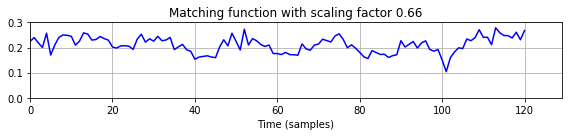

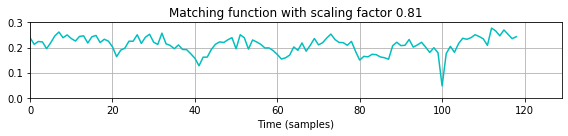

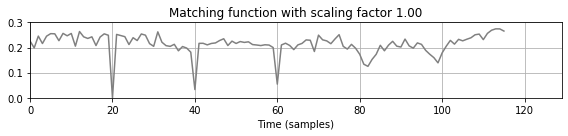

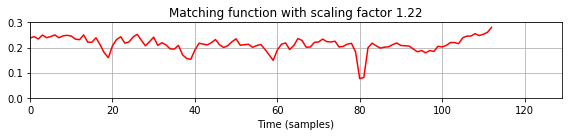

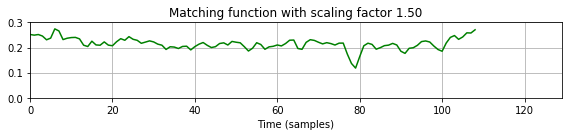

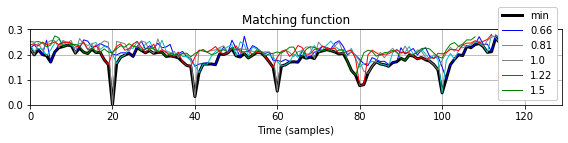

In [3]:
def matching_function_diag_multiple(X, Y, tempo_rel_set=[1], cyclic=False):
    """Computes diagonal matching function using multiple query strategy

    Notebook: C7/C7S2_DiagonalMatching.ipynb

    Args:
        X, Y: Feature seqeuences (given as K x N and K x M matrices)
        tempo_rel_set: Set of relative tempo values (scaling)
        cyclic: If "True" then matching is done cyclically

    Returns:
        Delta: Matching function
    """
    M = Y.shape[1]
    num_tempo = len(tempo_rel_set)
    Delta_scale = np.zeros((num_tempo, M))
    N_scale = np.zeros(num_tempo)
    for k in range(num_tempo):
        X_scale, N_scale[k] = scale_tempo_sequence(X, factor=tempo_rel_set[k])
        C_scale = cost_matrix_dot(X_scale, Y)
        Delta_scale[k, :] = matching_function_diag(C_scale, cyclic=cyclic)
    Delta_min = np.min(Delta_scale, axis=0)
    Delta_argmin = np.argmin(Delta_scale, axis=0)
    Delta_N = N_scale[Delta_argmin]
    return Delta_min, Delta_N, Delta_scale


# import LibFMP.C4
# tempo_rel_set = LibFMP.C4.compute_tempo_rel_set(tempo_rel_min=0.66, tempo_rel_max=1.5, num=5) 
# print(tempo_rel_set)

tempo_rel_set = [0.66, 0.81, 1.00, 1.22, 1.50]
color_set = ['b', 'c', 'gray', 'r', 'g']
num_tempo = len(tempo_rel_set)

Delta_min, Delta_N, Delta_scale = matching_function_diag_multiple(X, Y,  tempo_rel_set=tempo_rel_set,
                                                                  cyclic=False)

for k in range(num_tempo):
    LibFMP.B.plot_signal(Delta_scale[k,:], figsize=(8, 2), xlabel='Time (samples)',
                         title = 'Matching function with scaling factor %.2f' % tempo_rel_set[k], 
                         color=color_set[k], ylim=[0, 0.3])
    plt.grid()
    
fig, ax, line = LibFMP.B.plot_signal(Delta_min, figsize=(8, 2), xlabel='Time (samples)',
                     title = 'Matching function', color='k', ylim=[0,0.3], linewidth=3, label='min')
ax.grid()
for k in range(num_tempo):
    ax.plot(Delta_scale[k, :], linewidth=1, color=color_set[k], label=tempo_rel_set[k])
                     
plt.legend(loc='lower right', framealpha=1);

In the multiple-query matching function, the subsequences that correspond to stretched or compressed versions of the query are now revealed by local minima that have a value much closer to zero. As a result, our retrieval procedure from above (with the same parameter settings) now yields the expected matches. The length of the matching subsequence is derived from the scaled query that yields the minimal matching value over all query versions considered. Therefore, as also indicated in the subsequent figure, the length may differ from the length $N$ of the original (non-stretched) query. 

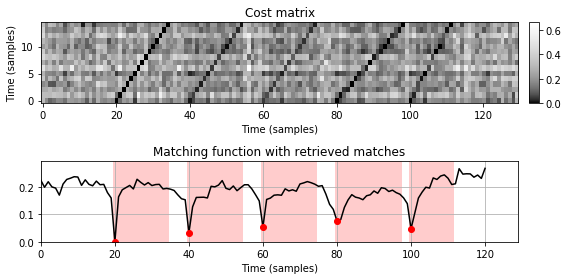

In [4]:
pos = mininma_from_matching_function(Delta_min, rho=N//2, tau=0.12, num=None)
matches = matches_diag(pos, Delta_N)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [3, 3]}, figsize=(8, 4))  
cmap = LibFMP.B.compressed_gray_cmap(alpha=-10, reverse=True)
LibFMP.B.plot_matrix(C, title='Cost matrix', xlabel='Time (samples)', ylabel='Time (samples)', 
                     ax=[ax[0, 0], ax[0, 1]], colorbar=True, cmap=cmap)

LibFMP.B.plot_signal(Delta_min, ax=ax[1, 0], xlabel='Time (samples)', 
                     title = 'Matching function with retrieved matches', color='k')

ax[1,0].grid()
plot_matches(ax[1, 0], matches, Delta_min)
ax[1,1].axis('off')
plt.tight_layout()

## Further Notes

In this notebook, we discussed a simple matching procedure that identifies database subsequences that are similar to a given query sequence. We have also shown how differences in tempo can be handled by using a multiple-query approach. 

* This matching strategy can be used for the task of [**audio matching**](../C7/C7S2_AudioMatching.html), which we introduced in the [FMP notebook on content-based audio retrieval](../C7/C7_ContentBasedAudioRetrieval.html).
* The matching strategy based on multiple queries was used in combination with [CENS features](../C7/C7S2_CENS.html) in the <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2005_MuellerKurthClausen_AudioMatching_ISMIR.pdf">original paper on audio matching</a>. 
* As an alternative to diagonal matching, we introduce in the [FMP notebook on subsequence DTW](../C7/C7S2_SubsequenceDTW.html) an alternative that can handle local tempo variations using a variant of [dynamic time warping](../C3/C3S2_DTWbasic.html) (DTW).


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>